In [1]:
from numpy import absolute, argmax, sign, exp
from numpy.random import random
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Modelo de línea de retardo
Modelamos una línea de retardo (''delay line'', DL) como una función que toma un valor $x$ (valor aspirante, almacenado en la memoria RAM) y un valor $y_n$, y produce el valor $y_{n+1}$:
\begin{equation}
    y_{n+1}=f(x, y_n)
\end{equation}
Con la propiedad: $\lim_{n\rightarrow \infty}y_{n+1}/y_n=1$, y "$n$" representando la evolución temporal de la señal de salida $y$.

Podemos hacer el cambio de variable $z_n\equiv y_n-x$, y reescribir:

\begin{equation}
    g(z_n)=g(y_n-x)\equiv f(x, y_n)
\end{equation}
Con esto podemos reescribir:
\begin{equation}
    z_{n+1}=g(z_n)
\end{equation}
Y cumpliendo ahora:
1) $\lim_{n\rightarrow \infty}=0$
2) $\frac{dg}{dz}|_{z=0} \equiv z^\prime |_{z=0}=0$

Así mismo podemos escribir esta expresión como:
\begin{equation}
    z_{n+1}-z_n = g(z_n)-z_n \equiv \delta\,h(z_n)
\end{equation}
donde $\delta$ es una constante con unidades de tiempo.

Podemos "codificar" esta ecuación en diferencias en forma de una ecuación diferencial:
\begin{equation}
    \dot{z}=h(z)
\end{equation}

Integramos la ecuación anterior mediante el método de Newton:
\begin{equation}
    z_{n+1}=z_n+\delta\,h(z_n)
\end{equation}

Dadas las propieades que debe cumplir la función $h$: $h(z<0)>0$, $h(0)=0$, y $h(z>0)<0$, podemos escribir esta función $h$ como:
\begin{equation}
    h(z)\equiv -\frac{dV}{dz}
\end{equation}
donde $V=V(z)$ es una función definida positiva con un mínimo en $z=0$.

Desde el punto de vista de la computación, una DL será una clase de objetos que se incializa con una función $V(z)$ y una constante con unidades de tiempo $\delta$, y consta de un procedimiento __call__ el cual toma una cantidad $z_n$, y devuelve la cantidad $z_{n+1}$.

In [2]:
def plot_func(func, x0=-1, x1=1, dx=0.1):
    X = [x0+i*dx for i in range(int((x1-x0)/dx+1))]
    Y = [func(x) for x in X]
    plt.plot(X, Y)
    plt.show()

def num_derivative(func, x, eps=1e-10):
    return (func(x+eps)-func(x-eps))/(2*eps)

def delayLineModel(ram_value, out_old, func_pot):
    result = out_old + num_derivative(func_pot, ram_value-out_old) #+0.1*(2*random()-1)
    if result > 1:
        result=1
    elif result < 0:
        result=0
    return result
    
def testEscalon(f):
    x=[0]
    y=[0]
    for i in range(1, 300):
        x.append(i)
        if i < 100:
            y.append(delayLineModel(0, y[-1], f))
        elif i>=100 and i<200:
            y.append(delayLineModel(1, y[-1], f))
        else:
            y.append(delayLineModel(0, y[-1], f))
    plt.plot(x,y)
    plt.show()

class LUT3:
    def __init__(self, config_ram, func_pot, I0='x', I1='x', I2='x', O='x'):
        self.ram = []
        for i in range(8):
            self.ram.append(config_ram%2)
            config_ram//=2
        self.func_pot = func_pot
        self.I0 = I0
        self.I1 = I1
        self.I2 = I2
        self.O = O
        
    def __call__(self, I0, I1, I2, O_old):
        if I0!='x':
            aux = round(I0)
        if I1!='x':
            aux+=2*round(I1)
        if I2!='x':
            aux+=4*round(I2) # Mitad del recorrido lógico
            
        return delayLineModel(self.ram[aux], O_old, self.func_pot)
    
    
class MODULO:
    def __init__(self, luts):
        self.luts = luts
        self.N = len(luts)
                        
        self.wnames=[]
        for i in luts:
            if i.I0 not in self.wnames:
                self.wnames.append(i.I0)
        for i in luts:
            if i.I1 not in self.wnames:
                self.wnames.append(i.I1)
        for i in luts:
            if i.I2 not in self.wnames:
                self.wnames.append(i.I2)
        for i in luts:
            if i.O not in self.wnames:
                self.wnames.append(i.O)
        
        self.w_old=[]
        for wname in self.wnames:
            if wname == 'x':
                self.w_old.append('x')
            else:
                self.w_old.append(random()) # Inicializar valores en los cables.
        self.w = self.w_old[:]
        
    def step(self):
        for lut in self.luts:
            O_index = self.wnames.index(lut.O)
            I0_index = self.wnames.index(lut.I0)
            I1_index = self.wnames.index(lut.I1)
            I2_index = self.wnames.index(lut.I2)
            
            self.w[O_index] = lut(I0=self.w_old[I0_index], I1=self.w_old[I1_index], I2=self.w_old[I2_index], O_old=self.w_old[O_index])
        
        for i in range(len(self.w)):
            self.w_old[i] = self.w[i]
            
    def setw(self, name, value):
        self.w_old[self.wnames.index(name)]=value
        self.w[self.wnames.index(name)]=value
        
    def probe(self, name):
        return self.w_old[self.wnames.index(name)]
            
    def read(self, names):
        for i in range(len(names)):
            print(f" cable \"{names[i]}\" = {self.w_old[self.wnames.index(names[i])]}")

            
def printUnicodeExp(numero):            
    super_unicode = ["\u2070","\u00B9","\u00B2","\u00B3","\u2074","\u2075","\u2076","\u2077","\u2078","\u2079"]
    result=""
    aux=[]
    while numero>0:
        aux.append(numero%10)
        numero//=10
    aux.reverse()
    result=""
    for i in aux:
        result+=super_unicode[i]
    return result


def factores_to_garopol(entrada, ):
    """
    Esto funciona un poco mal
    """
    
    entrada_bin=[]
    while entrada>0:
        entrada_bin.append(entrada%2)
        entrada//=2
    
    N=len(entrada)+1
    result="1"
    for i in range(1, N):
        if entrada[-i]:
            if i==1:
                result+="+x"
            else:
                result+=f"+x{printUnicodeExp(i)}"
    if N==1:
        result+="+x"
    else:
        result+=f"+x{printUnicodeExp(N)}"
    
    print(result)
            

In [7]:
factores_to_garopol([0,1,0,0,0,0])

1+x⁵+x⁷


In [10]:
def func_lineal(x):
    if x < 0:
        return -x*0.1
    else:
        return x*0.1
    
def func_pol(x):
    return 0.5*x**2
    
def func_exp(x):
    return -exp(-5*x**2)


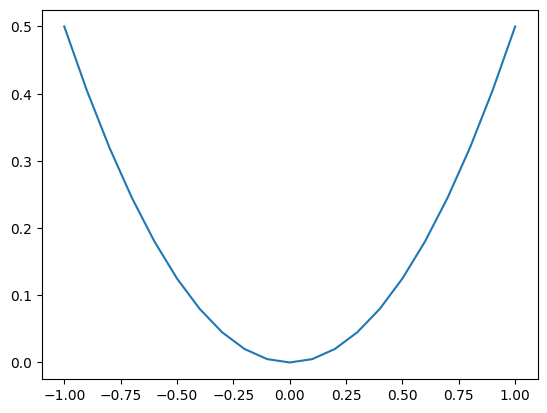

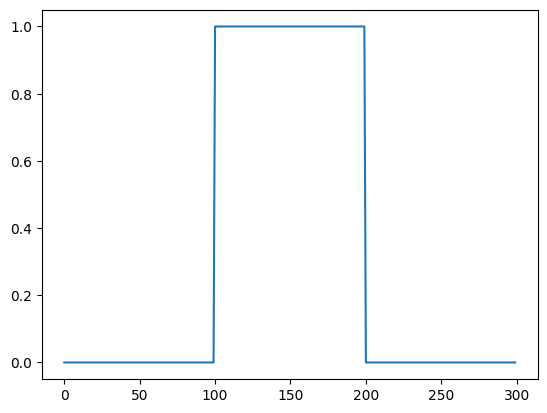

In [11]:
func=func_pol

plot_func(func)
testEscalon(func)

In [12]:
def tspan(t0=0, t1=100, dt=1):
    return [t0+i*dt for i in range(int((t1-t0)/dt))] 


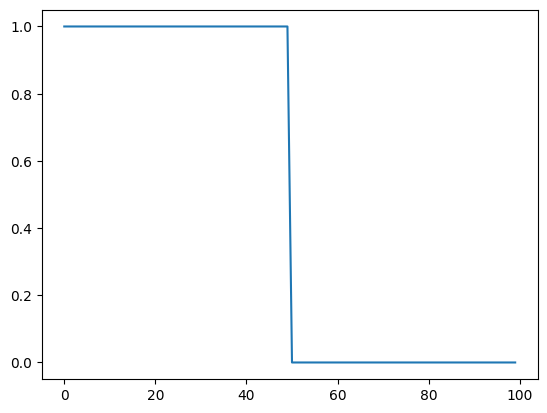

In [13]:
lut = LUT3(1, func, I0="in", O="out")
modulo = MODULO([lut])

x = []
y = []
for t in tspan():
    if t == 0:
        modulo.setw("in",0)
    elif t == 50:
        modulo.setw("in",1)
        
    modulo.step()
    
    x.append(t)
    y.append(modulo.probe("out"))


        
plt.plot(x,y)
plt.show()

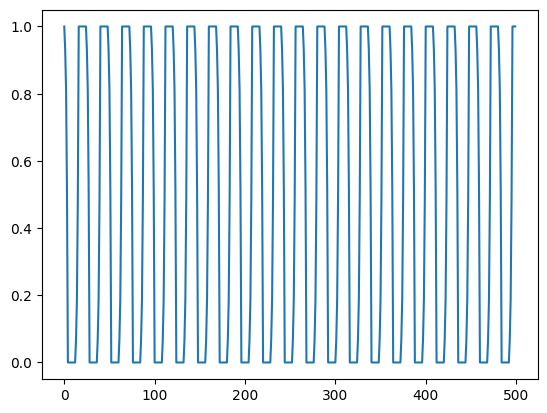

In [12]:
func = func_exp

lut0 = LUT3(1, func, I0="w0", O="w1")
lut1 = LUT3(1, func, I0="w1", O="w2")
lut2 = LUT3(1, func, I0="w2", O="w0")

modulo = MODULO([lut0,lut1,lut2])

x = []
y = []
for t in tspan(t1=500):       
    modulo.step()
    
    x.append(t)
    y.append(modulo.probe("w0"))

plt.plot(x,y)
plt.show()

In [344]:
def medir_freq(signal, dt=1):
    x_freq = fftfreq(len(signal), d=dt)[1:len(signal)//2]
    y_freq = fft(signal)[1:len(signal)//2]
    
    return x_freq[argmax(y_freq)]

In [345]:
print(f"{medir_freq(y, dt=1):.5}")

0.042


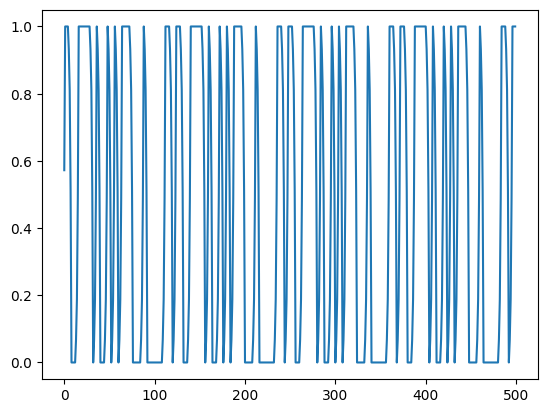

In [18]:
func = func_exp


lut0 = LUT3(1,   func, I0="w4", O="w0") # inv
lut1 = LUT3(149, func, I0="w0", I1="w4", I2="pol1", O="w1")
lut2 = LUT3(149, func, I0="w1", I1="w4", I2="pol2", O="w2")
lut3 = LUT3(149, func, I0="w2", I1="w4", I2="pol3", O="w3")
lut4 = LUT3(149, func, I0="w3", I1="w4", I2="pol4", O="w4")


modulo = MODULO([lut0,lut1,lut2,lut3,lut4])
modulo.setw("pol1", 1)
modulo.setw("pol2", 1)
modulo.setw("pol3", 1)
modulo.setw("pol4", 0)

x = []
y = []
for t in tspan(t1=500, dt=1):
    modulo.step()
    
    x.append(t)
    y.append(modulo.probe("w4"))

plt.plot(x,y)
plt.show()

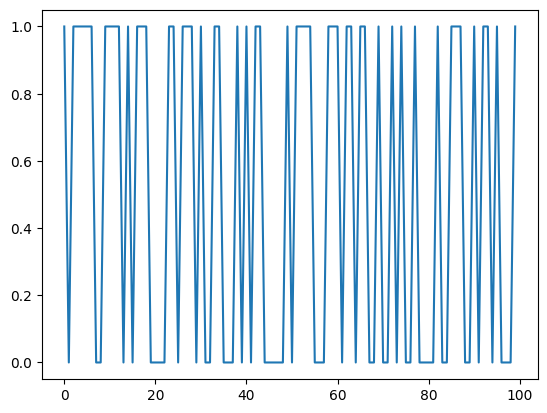

In [38]:
func = func_pol


lut0 = LUT3(149, func, I0="w6", I1="w6", I2="pol0", O="w0")
lut1 = LUT3(149, func, I0="w0", I1="w6", I2="pol1", O="w1")
lut2 = LUT3(149, func, I0="w1", I1="w6", I2="pol2", O="w2")
lut3 = LUT3(149, func, I0="w2", I1="w6", I2="pol3", O="w3")
lut4 = LUT3(149, func, I0="w3", I1="w6", I2="pol4", O="w4")
lut5 = LUT3(149, func, I0="w4", I1="w6", I2="pol5", O="w5")
lut6 = LUT3(149, func, I0="w5", I1="w6", I2="pol6", O="w6")

modulo = MODULO([lut0,lut1,lut2,lut3,lut4,lut5,lut6])
modulo.setw("pol0", 0)
modulo.setw("pol1", 1)
modulo.setw("pol2", 0)
modulo.setw("pol3", 0)
modulo.setw("pol4", 0)
modulo.setw("pol5", 0)
modulo.setw("pol6", 0)
x = []
y = []
for t in tspan(t1=100, dt=1):
    modulo.step()
    
    x.append(t)
    y.append(modulo.probe("w6"))

plt.plot(x,y)
plt.show()

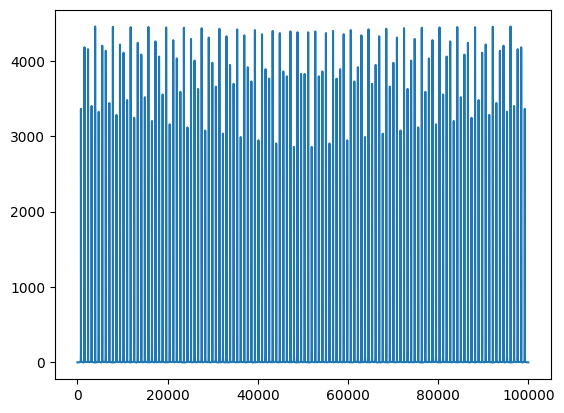

In [36]:
y_fft = absolute(fft(y))

plt.plot([i for i in range(len(y_fft[1:]))], y_fft[1:])

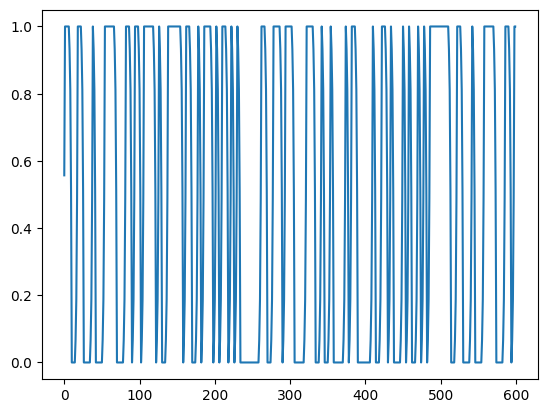

In [382]:
func = func_exp


lut0 = LUT3(1, func, I0="w6", O="w0") # inv
lut1 = LUT3(9, func, I0="w0", I1="w6", O="w1") # xnor
lut2 = LUT3(1, func, I0="w1", O="w2") # inv
lut3 = LUT3(1, func, I0="w2", O="w3") # inv
lut4 = LUT3(1, func, I0="w3", O="w4") # inv
lut5 = LUT3(9, func, I0="w4", I1="w6", O="w5") # xnor
lut6 = LUT3(1, func, I0="w5", O="w6") # inv

modulo = MODULO([lut0, lut1, lut2, lut3, lut4, lut5, lut6])

x = []
y = []
for t in tspan(t1=600):
        
    modulo.step()

    x.append(t)
    y.append(modulo.probe("w6"))

plt.plot(x,y)
plt.show()